# Radio Lab 2 - Analysis

In [35]:
# import statements

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
import astropy.units as u
import os
from astropy.io import fits

In [39]:
srt_file="lab2kore.rad"
infile = open(srt_file)
for line in infile.readlines():
    print(line)
    
# T_sys = 849

* STATION LAT=  43.07 DEG LONGW=  89.41

* riya.cmd: line 1 : record lab2kore.rad

2024:283:21:06:21    0.0   0.0   0.0   0.0  1419.75 0.00781250   1  64  23.0  29.0  50.0 104.0 205.0 354.0 570.0 764.0 1089.5 1094.2 1064.4 1073.6 1104.6 1083.4 1091.9 1089.6 1116.2 1077.8 1086.2 1087.0 1099.2 1078.1 1115.8 1094.5 1078.3 1066.8 1058.0 1080.2 1089.3 1107.6 1102.5 1080.2 1117.0 1080.2 1091.8 1090.3 1083.6 1074.5 1100.6 1072.7 1052.9 1068.9 1102.5 1066.0 1095.2 1076.3 1086.2 1095.6 1095.0 1091.7 1082.7 1093.6 1060.1 1108.4 1118.0 1075.6 1063.7 753.0 526.0 338.0 198.0 103.0  50.0  29.0

* riya.cmd: line 2 : freq 1420.405 4

2024:283:21:06:28    0.0   0.0   0.0   0.0  1419.80 0.00781250   4 156  19.6  25.7  46.8 102.0 201.1 340.3 579.4 757.5 1103.8 1088.9 1119.9 1062.0 1073.2 1097.0 1102.8 1109.8 1069.6 1076.7 1071.5 1075.5 1061.9 1074.6 1079.7 1107.6 1085.2 1126.2 1060.1 1064.3 1109.7 1087.9 1072.9 1091.0 1074.0 1109.2 1102.8 1092.6 1105.1 1088.5 1066.6 1109.3 1055.1 1107.0 1082.4 1086.7 108

## Code to read a FITS data cube

In [42]:
lds_file = '/Users/riyakore/Desktop/Astronomy/Astron_465/Radio Lab 2/LDSfull.fits'
lds_cube = fits.open(lds_file)
lds_data = lds_cube[0].data
print(lds_data.shape)

# in this case: 389 values along the velocity axis (z), 361 pixels along the y and 720 pixels along the x 

(389, 361, 720)


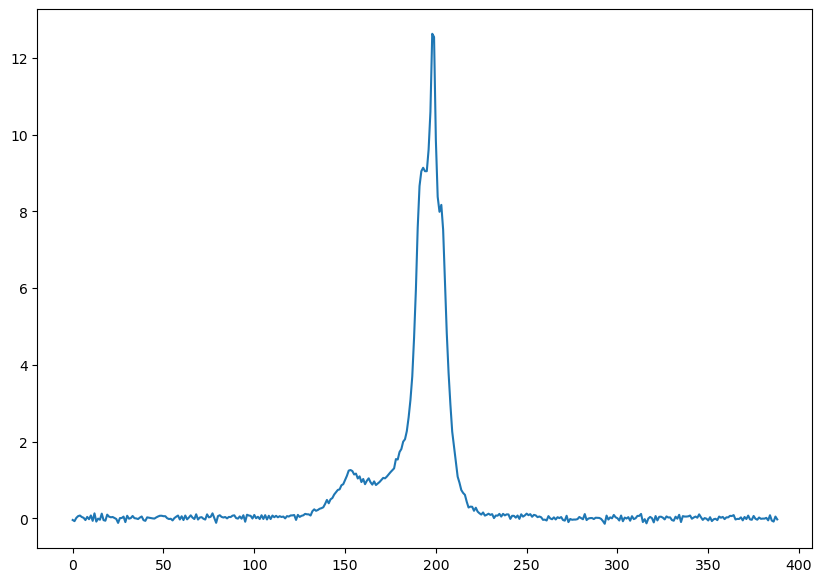

In [44]:
# to extract and plot a single spectrum at pixel position (120, 150):
lds_spectrum = lds_data[:, 120, 150]
plt.figure(figsize = (10,7))
plt.plot(lds_spectrum)
plt.show()

In [46]:
# to get the header information from the FITS file.
# the header contains info about coordinate axes which is important
# for search for the right (l, b) position in the cube.

lds_header = lds_cube[0].header
print(lds_header)
lds_cube.close()

SIMPLE  =                    T / Written by IDL:  Mon Mar 26 16:12:26 2012      BITPIX  =                  -64 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  720 /                                                NAXIS2  =                  361 /                                                NAXIS3  =                  389 /                                                CRVAL1  =              180.000 /                                                CRPIX1  =              361.000 /                                                CDELT1  =             0.500000 /                                                CTYPE1  = 'GLON-CAR'           /                                                CRVAL2  =              0.00000 /                                                CRPIX2  =              181.000 /                                                CDELT2  =             0.500000 /        

In [48]:
## Read from the header velocity axis information:

# converting all velocities from m/s to km/s
velocity_center = lds_header["CRVAL3"]/1000.
velocity_inc = lds_header["CDELT3"]/1000.
velocity_pix = lds_header["CRPIX3"]

print(velocity_center, velocity_inc, velocity_pix)

0.0 1.0305 195.0


In [50]:
# have as many velocity channels as are in the spectrum
channels = np.arange(len(lds_spectrum))

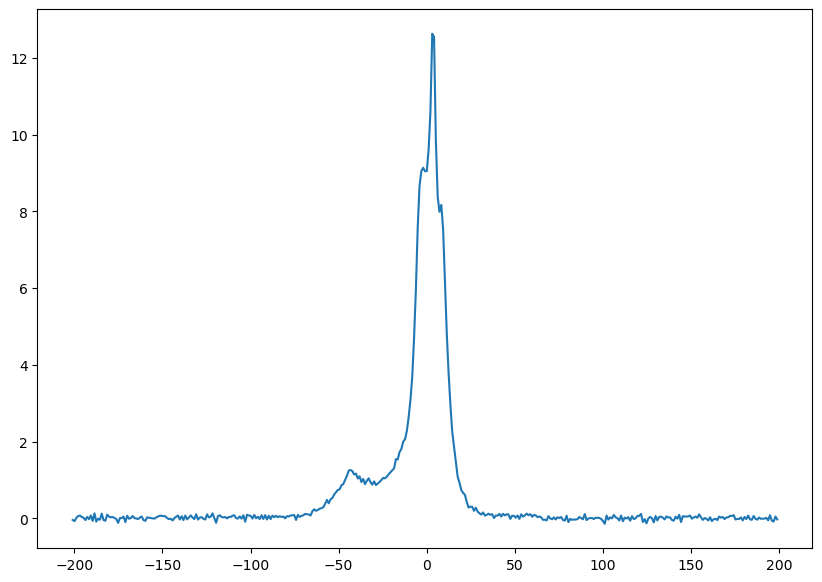

In [52]:
# define velocity as km/s blocks
# also centering the same plot as above around 0
velocity = velocity_center + velocity_inc * (channels - velocity_pix)
velocity = np.array(velocity, dtype = float)
plt.figure(figsize = (10, 7))
plt.plot(velocity,lds_spectrum)
plt.show()

## Analysis Section of the lab

### part 1 - reading the srt file and storing the tsys value

In [121]:
# integration time - 600/15 because the telescope needs time to trasnfer the data and this is included in the total integration time
# mention where the noise equation comes from in the report

frequency = []
intensities = []
lines_list = []

srt_file="lab2kore.rad"
infile = open(srt_file)

start_reading = False

for line in infile.readlines():

    # extract the tsys value
    if line.startswith("*"):
        if "tsys" in line:
            line.strip().split()
            tsys = int(line[9:12]) # in kelvin

    if "* riya.cmd: line 7 :600" in line:
        start_reading = True
        continue

    if start_reading:
        line_list = line.strip().split()
        # this is to see how many samples of the data we collected - in our cause it is 78
        lines_list.append(line_list)
        intensity = np.array(line_list[9:165], dtype = float)
        start_frequency = float(line_list[5])
        freq_channel_width = float(line_list[6])
        num_freq_channels = float(line_list[8])
        intensities.append(intensity)
        
        
infile.close()

intensities_array = np.array(intensities)
print(start_frequency,freq_channel_width, num_freq_channels )

1419.79 0.0078125 156.0


### part 2 - producing the avg HI spectrum

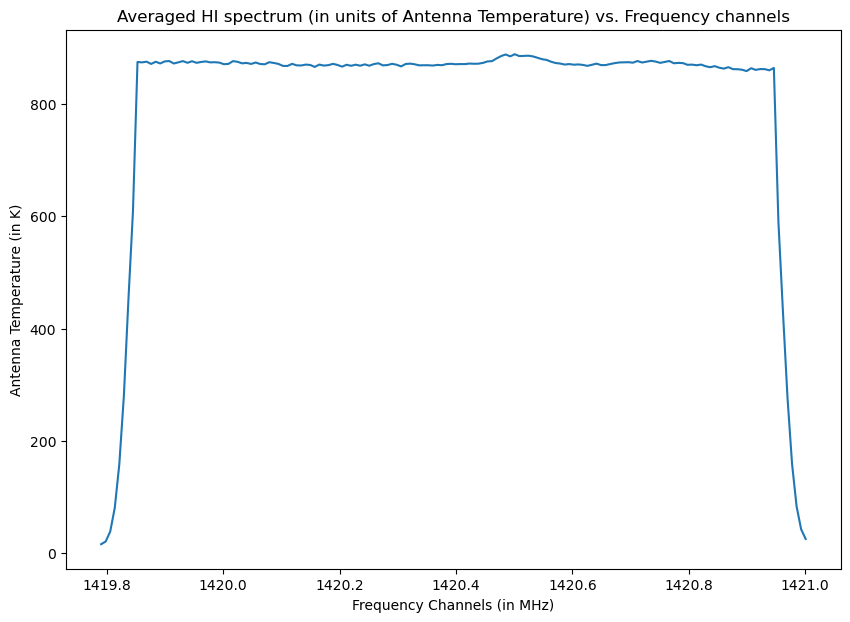

In [124]:
# averaging the intensities across the arrays - using axis = 0
averaged_intensity = np.mean(intensities_array, axis=0)
freq_vals = np.array(start_frequency + np.arange(0, num_freq_channels) * freq_channel_width)

plt.figure(figsize = (10,7))
plt.plot(freq_vals, averaged_intensity)
plt.xlabel("Frequency Channels (in MHz)")
plt.ylabel("Antenna Temperature (in K)")
plt.title("Averaged HI spectrum (in units of Antenna Temperature) vs. Frequency channels")
plt.show()

Now convert the frequency into topocentric radial frequency, use this equation: \
\$ v_{r} = c \times \frac{f_{o} - f}{f_{0}} \$

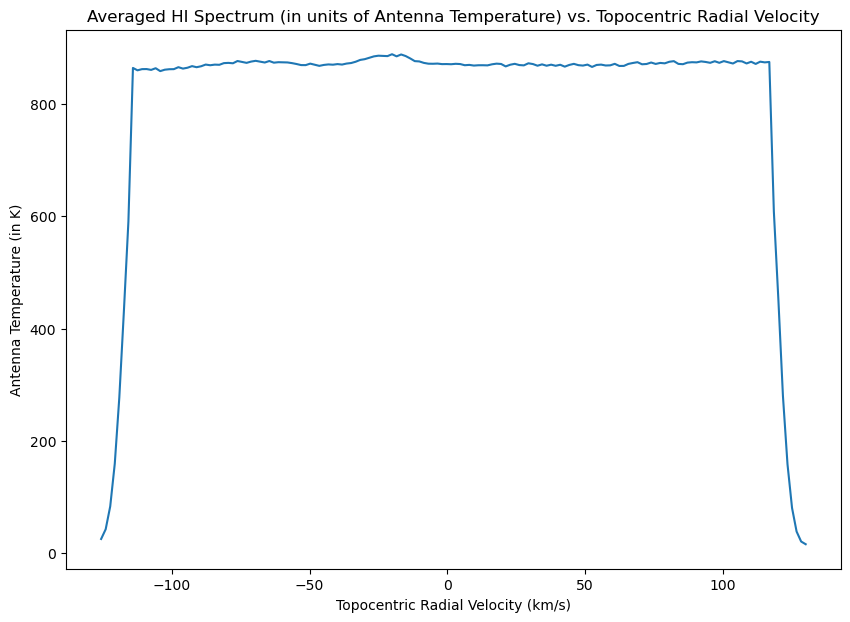

In [127]:
c = 3e8
rest_frequency = 1420.405751

topocentric_r_velocity = np.array(c * ((rest_frequency - freq_vals)/ rest_frequency))
# to convert from m to km
topocentric_r_velocity = topocentric_r_velocity / 1000

plt.figure(figsize=(10, 7))
plt.plot(topocentric_r_velocity, averaged_intensity)
plt.xlabel("Topocentric Radial Velocity (km/s)")
plt.ylabel("Antenna Temperature (in K)")
plt.title("Averaged HI Spectrum (in units of Antenna Temperature) vs. Topocentric Radial Velocity")
plt.show()

Now, applying the cuts from the topocentric radial velocity to only include the values ranging from [-114, 114]

In [130]:
indices_to_include = np.logical_and(topocentric_r_velocity > -114, topocentric_r_velocity < 114)
averaged_intensity = averaged_intensity[indices_to_include]
freq_vals = freq_vals[indices_to_include]
topocentric_r_velocity = topocentric_r_velocity[indices_to_include]

Now perform a linear polynomial fit to the frequency channels with no obvious HI emission to model the spectral baseline. After this, subtract the basline from the spectrum.

In [133]:
baseline_indices = np.logical_and(topocentric_r_velocity > 20, topocentric_r_velocity < 114)
avg_intensity_for_baseline = averaged_intensity[baseline_indices]
freq_vals_baseline = freq_vals[baseline_indices]
velocity_basline = topocentric_r_velocity[baseline_indices]

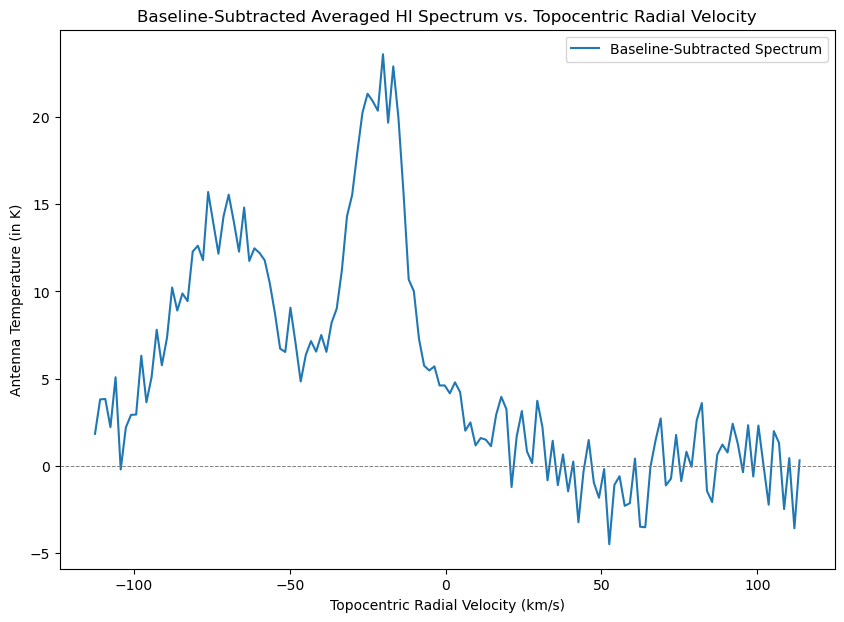

In [135]:
coefficients = np.polyfit(freq_vals_baseline, avg_intensity_for_baseline, deg=1)
baseline = np.polyval(coefficients, freq_vals)
baseline_subtracted_intensity = averaged_intensity - baseline

plt.figure(figsize=(10, 7))
plt.plot(topocentric_r_velocity, baseline_subtracted_intensity, label='Baseline-Subtracted Spectrum')
plt.xlabel("Topocentric Radial Velocity (km/s)")
plt.ylabel("Antenna Temperature (in K)")
plt.title("Baseline-Subtracted Averaged HI Spectrum vs. Topocentric Radial Velocity")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.legend()
plt.show()

### part 3 - extracting the H1 spectrum from the LDS survey

In [138]:
lds_header = lds_cube[0].header
print(lds_header)
lds_cube.close()

SIMPLE  =                    T / Written by IDL:  Mon Mar 26 16:12:26 2012      BITPIX  =                  -64 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  720 /                                                NAXIS2  =                  361 /                                                NAXIS3  =                  389 /                                                CRVAL1  =              180.000 /                                                CRPIX1  =              361.000 /                                                CDELT1  =             0.500000 /                                                CTYPE1  = 'GLON-CAR'           /                                                CRVAL2  =              0.00000 /                                                CRPIX2  =              181.000 /                                                CDELT2  =             0.500000 /        

In [140]:
# Read from the header the information of galactic longitude and latitude
# we need to extract the velocity axis (z axis)  information from the galactic longitude 110.0 and galactic latitude 0
# in the header file, variables with 1 represent x - longitude
# variables with 2 represent y - latitude
# variables with 3 represent z - velocity

# storing these variables for easy access later

# total number of pixels
# number of velocity channels along the z axis
num_pix_x = lds_header["NAXIS1"]
num_pix_y = lds_header["NAXIS2"]
num_pix_z = lds_header["NAXIS3"]

# central reference value - galactic longitude and latitude for x and y respectively
# longtitude goes from 0 to 360
# latitude goes from -90 to 90
# central value of velocity for z
center_value_lon = lds_header["CRVAL1"]
center_value_lat = lds_header["CRVAL2"]
center_value_velocity = lds_header["CRVAL3"]

# pixel position corresponding to the center reference value
center_pix_x = lds_header["CRPIX1"]
center_pix_y = lds_header["CRPIX2"]
center_pix_z = lds_header["CRPIX3"]

# increments (step size) per pixel along x, y, z axes respectively
delta_pix_x = lds_header["CDELT1"]
delta_pix_y = lds_header["CDELT2"]
delta_pix_z = lds_header["CDELT3"]

To convert from galactic longitude and latitude to pixels, we use the formula: \
\$ \text{pixel} = \text{center pix} + \frac{\text{coordinate} - \text{center value}}{\text{delta pix}} \$

In [143]:
# galactice longtitude
lon = 110
lon_pix = int(center_pix_x + ((lon - center_value_lon)/ delta_pix_x))

# galactic latitude
lat = 0
lat_pix = int(center_pix_y + ((lat - center_value_lat)/ delta_pix_y))

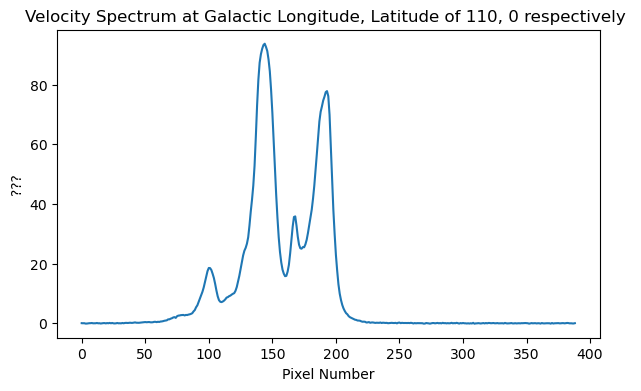

In [144]:
# this is not averaged for 12 x 12 pixel range
# you dont need to include this in the lab report
lonlat_spectrum = lds_data[:, lat_pix, lon_pix]
plt.figure(figsize = (7,4))
plt.plot(lonlat_spectrum)
plt.title("Velocity Spectrum at Galactic Longitude, Latitude of 110, 0 respectively ")
plt.xlabel("Pixel Number")
plt.ylabel("???")
plt.show()

In [147]:
channels = np.arange(len(lonlat_spectrum))

In [148]:
velocity = center_value_velocity + delta_pix_z * (channels - center_pix_z)
velocity = np.array(velocity / 1000, dtype = float)

Averaging it for 12 x 12 pixels around the selected position

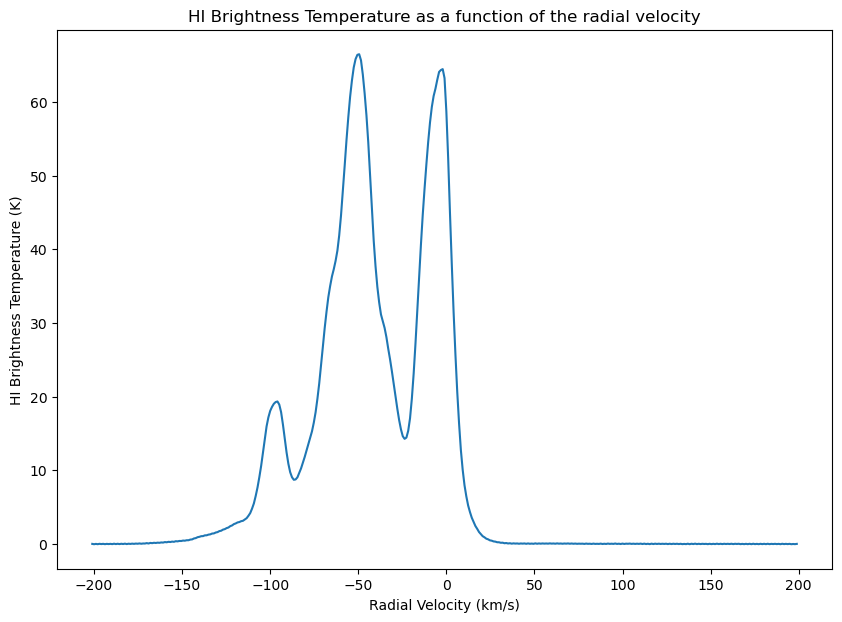

In [152]:
lds_spectra = []

for y in range(175, 187):
    for x in range(215, 227):
        spectrum = np.array(lds_data[:, y, x])
        lds_spectra.append(spectrum)

lds_spectra_subcube = np.array(lds_spectra)
avg_lds_spectrum = np.mean(lds_spectra_subcube, axis = 0)
plt.figure(figsize = (10, 7))
plt.plot(velocity,avg_lds_spectrum)
plt.ylabel("HI Brightness Temperature (K)")
plt.xlabel("Radial Velocity (km/s)")
plt.title("HI Brightness Temperature as a function of the radial velocity")
plt.show()

Next step is to compare the HI spectra for our observations at (110,0) and the LDS observations at (110,0) but averaged across a 12 x 12 cube around that point. \
We need to find the scaling factor so as to scale our observations to match the LDS observations. The formuala used to calculate the scaling factor is: \
\$ \eta = \frac{\text{Peak Intensity (LDS)}}{\text{Peak Intensity (our observations)}} \$  \
After this, we multiply our observations with this scaling factor

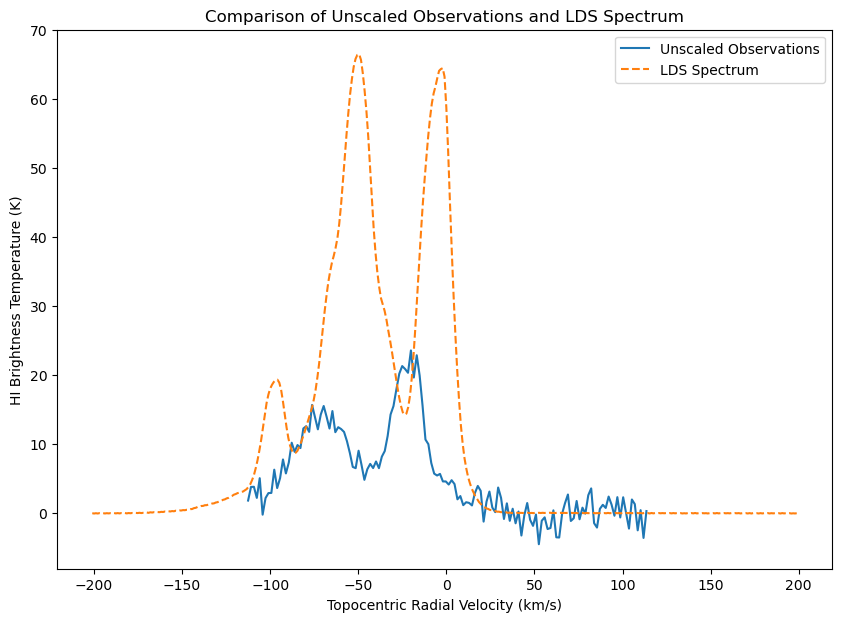

In [155]:
# without scaling the spectrum and adding the constant to the topocentric radial velocity
plt.figure(figsize=(10, 7))
plt.plot(topocentric_r_velocity , baseline_subtracted_intensity, label='Unscaled Observations')
plt.plot(velocity, avg_lds_spectrum, label='LDS Spectrum', linestyle='--')
plt.xlabel("Topocentric Radial Velocity (km/s)")
plt.ylabel("HI Brightness Temperature (K)")
plt.title("Comparison of Unscaled Observations and LDS Spectrum")
# plt.ylim(-0.4,)
plt.legend()
plt.show()

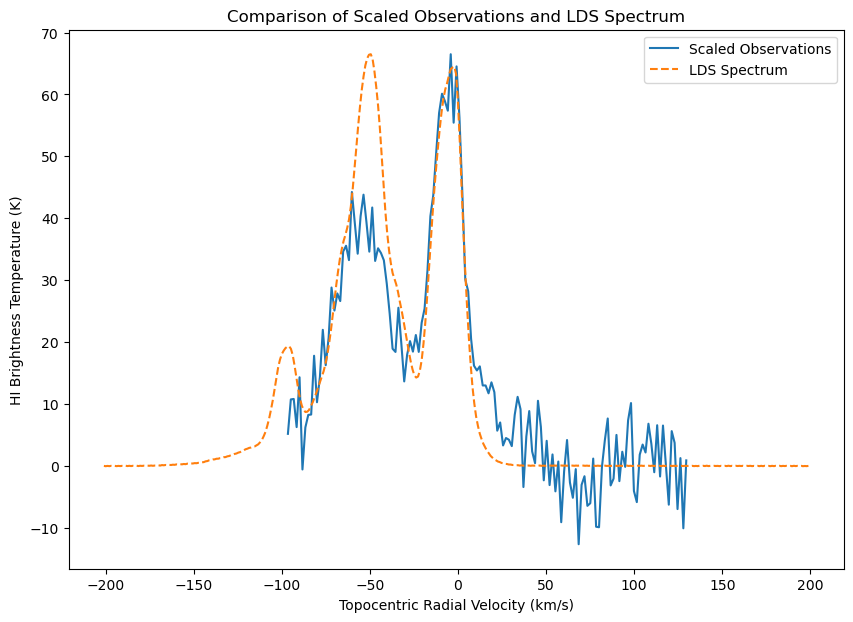

In [156]:
# after scaling the spectrum and adding the constant to the topocentric frequency

peak_intensity_your_obs = np.max(baseline_subtracted_intensity)
peak_intensity_lds = np.max(avg_lds_spectrum)

scaling_factor = peak_intensity_lds / peak_intensity_your_obs
scaled_spectrum = baseline_subtracted_intensity * scaling_factor

plt.figure(figsize=(10, 7))
plt.plot(topocentric_r_velocity + 16, scaled_spectrum, label='Scaled Observations')
plt.plot(velocity, avg_lds_spectrum, label='LDS Spectrum', linestyle='--')
plt.xlabel("Topocentric Radial Velocity (km/s)")
plt.ylabel("HI Brightness Temperature (K)")
plt.title("Comparison of Scaled Observations and LDS Spectrum")
# plt.ylim(-0.4,)
plt.legend()
plt.show()

In [158]:
print(scaling_factor)

2.8192622918492924


The scaling factor I got is 2.819 \
I have used this scaling factor to callibrate my data to match it to the LDS data. \
This scaling factor is also called scaling the main beam efficiency. \
The two spectra are very similar to each other but I had to add a constant to my observed spectrum to center it around 0.

### part 4 - estimating of Tsys

In [163]:
indices = np.logical_and(topocentric_r_velocity > 30, topocentric_r_velocity < 100)
scaled_spectrum = scaled_spectrum[indices]
scaled_freq_vals = freq_vals[indices]
scaled_velocity = topocentric_r_velocity[indices]

In [165]:
rms_noise = np.sqrt(np.mean(scaled_spectrum**2))
rms_noise

5.193146693413242

In [167]:
integration_time = float(600/15)
# converting it from MHz from Hz
freq_resolution = 0.0078125 * 1e6
freq_resolution

7812.5

In [168]:
tsys_calculated = rms_noise * np.sqrt(freq_resolution * integration_time)
tsys_calculated

2903.057255900067

The estimated tsys value from step 1 was 849 and the calculated tsys value I got is about 3000 K. \
The two values are very different. The reason behind this is the srt's diode not working properly.

### part 5 - optional - radiometer

The number of scans for me is 78.

In [174]:
print(intensities_array)
print(len(intensities_array))

[[11.4 16.  34.6 ... 89.3 48.4 30.3]
 [ 9.2 13.9 33.4 ... 90.4 50.5 33.3]
 [17.2 22.5 40.1 ... 82.2 42.1 24.6]
 ...
 [23.1 28.2 46.4 ... 77.8 35.7 19. ]
 [13.5 18.9 35.7 ... 82.1 44.7 27.4]
 [23.3 26.7 44.  ... 77.6 36.4 18.8]]
78


In [176]:
avg_int_5_scans = np.mean(intensities_array[0:5], axis = 0) * scaling_factor
avg_int_10_scans = np.mean(intensities_array[0:10], axis = 0) * scaling_factor
avg_int_20_scans = np.mean(intensities_array[0:20], axis = 0) * scaling_factor
avg_int_40_scans = np.mean(intensities_array[0:40], axis = 0) * scaling_factor
avg_int_60_scans = np.mean(intensities_array[0:60], axis = 0) * scaling_factor
avg_int_78_scans = np.mean(intensities_array[0:78], axis = 0) * scaling_factor

In [178]:
freq_vals = np.array(start_frequency + np.arange(0, num_freq_channels) * freq_channel_width)
topocentric_r_velocity = np.array(c * ((rest_frequency - freq_vals)/ rest_frequency))
# to convert from m to km
topocentric_r_velocity = topocentric_r_velocity / 1000

def get_rmsnoise(avg_int ,f_freq_vals, f_topocentric_r_velocity, velocity_low , velocity_high ):
    baseline_indices = np.logical_and(f_topocentric_r_velocity > velocity_low, f_topocentric_r_velocity < velocity_high)
    avg_int = avg_int[baseline_indices]
    f_freq_vals = f_freq_vals[baseline_indices]
    f_topocentric_r_velocity = f_topocentric_r_velocity[baseline_indices]

    coeffs = np.polyfit(f_freq_vals,avg_int, deg = 1)
    baseline = np.polyval(coeffs, f_freq_vals)

    baseline_subtracted_int = avg_int - baseline

    rms_noise = np.sqrt(np.mean(baseline_subtracted_int**2))

    return rms_noise

In [180]:
rms_5 = get_rmsnoise(avg_int_5_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_10 = get_rmsnoise(avg_int_10_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_20 = get_rmsnoise(avg_int_20_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_40 = get_rmsnoise(avg_int_40_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_60 = get_rmsnoise(avg_int_60_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_78 = get_rmsnoise(avg_int_78_scans, freq_vals, topocentric_r_velocity, 24, 114)
rms_noises = [rms_5, rms_10, rms_20, rms_40, rms_60, rms_78]
num_scans = [5, 10, 20, 40, 60, 78]

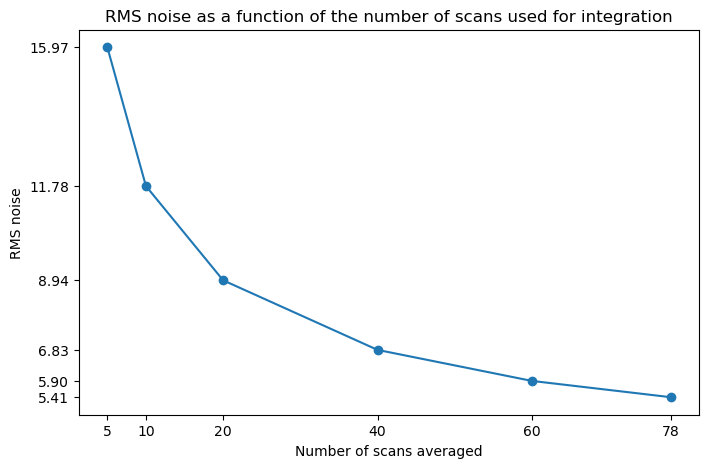

In [182]:
plt.figure(figsize = (8, 5))
plt.plot(num_scans, rms_noises, marker = 'o')
plt.xticks(num_scans)
plt.yticks(rms_noises)
plt.xlabel("Number of scans averaged")
plt.ylabel("RMS noise")
plt.title("RMS noise as a function of the number of scans used for integration")
plt.show()